# Importação das bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

from nltk.corpus import stopwords
from wordcloud import WordCloud

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

from sklearn.metrics import auc
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Carregamento, pré-processamento e análise exploratória dos dados

## Carregamento do conjunto de dados

In [3]:
data = pd.read_csv('data/b2w.csv')
data.head()

,original_index,review_text,review_text_processed,review_text_tokenized,polarity,rating,kfold_polarity,kfold_rating
0,11955,Bem macio e felpudo...recomendo. Preço imbatí...,bem macio e felpudo...recomendo. preco imbati...,"['bem', 'macio', 'felpudo', 'recomendo', 'prec...",1.0,4,1,1
1,35478,Produto excepcional! recomendo!!! inovador e ...,produto excepcional! recomendo!!! inovador e ...,"['produto', 'excepcional', 'recomendo', 'inova...",1.0,5,1,1
2,122760,recebi o produto antes do prazo mas veio com d...,recebi o produto antes do prazo mas veio com d...,"['recebi', 'produto', 'antes', 'do', 'prazo', ...",0.0,1,1,1
3,17114,Bom custo beneficio. Adequado para pessoas que...,bom custo beneficio. adequado para pessoas que...,"['bom', 'custo', 'beneficio', 'adequado', 'par...",1.0,5,1,1
4,19112,Além de higiênico tem o tamanho ideal. Só falt...,alem de higienico tem o tamanho ideal. so falt...,"['alem', 'de', 'higienico', 'tem', 'tamanho', ...",NaN,3,-1,1


## Pré-processamento

In [7]:
data = data[['review_text_processed', 'polarity']].dropna()
data

,review_text_processed,polarity
0,bem macio e felpudo...recomendo. preco imbati...,1.0
1,produto excepcional! recomendo!!! inovador e ...,1.0
2,recebi o produto antes do prazo mas veio com d...,0.0
3,bom custo beneficio. adequado para pessoas que...,1.0
5,"otmo produto atendeu as expectativas, a entreg...",1.0
...,...,...
132367,"otimo jogo, um dos melhores que joguei. entreg...",1.0
132368,smarthphone perfeito muito bom e a econo...,1.0
132369,eu estou muito chateado com isso gostaria que ...,0.0
132371,o produto anunciado no site dizia ser 100% al...,0.0


## Distribuição dos dados entre as classes

In [8]:
fig = px.bar(x = np.unique(data['polarity']),
             y = [list(data['polarity']).count(i) for i in np.unique(data['polarity'])],
             color = np.unique(data['polarity']),
             color_continuous_scale = 'Emrld')
fig.update_xaxes(title = 'Avaliação')
fig.update_yaxes(title = 'Número de avaliações')
fig.update_layout(showlegend = True,
  title = {
    'text': 'Avaliação vs Número de avaliações',
    'y': 0.95,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top'

  })
fig.show()

## Nuvem de palavras

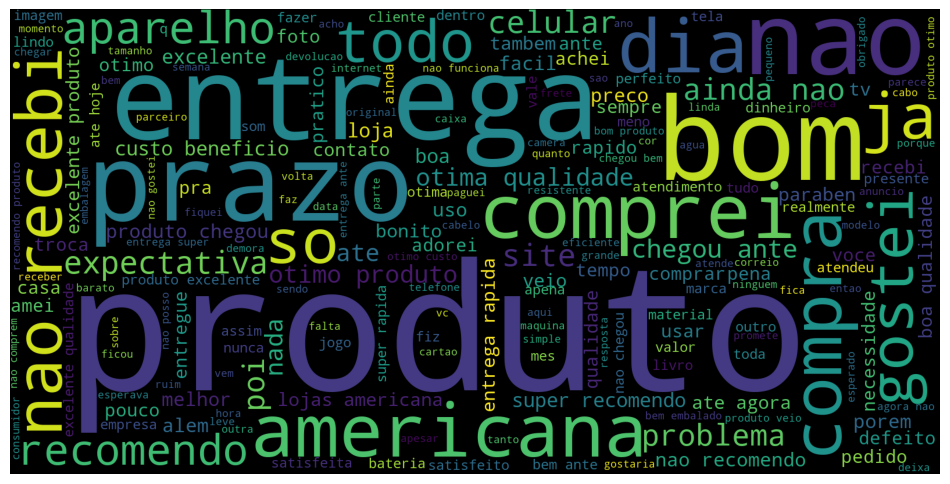

In [9]:
stop_words = stopwords.words('portuguese')
wordcloud = WordCloud(stopwords = stop_words,
                      background_color = 'black',
                      width = 1600, height = 800).generate(' '.join(data['review_text_processed']))
fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(wordcloud, interpolation = 'bilinear')
ax.set_axis_off()
plt.imshow(wordcloud)

## Divisão dos dados em conjuntos de treino e teste

In [10]:
from sklearn.model_selection import train_test_split

X = np.array(data['review_text_processed'].values.tolist())
y = np.array(data['polarity'].values.tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 12, stratify = y)
print (len(X_train),len(X_test),len(y_train),len(y_test))

87043 29015 87043 29015


## Tokenização e padding

In [11]:
tokenizer = Tokenizer(num_words = 10000, oov_token = '<OOV>')
tokenizer.fit_on_texts(X_train)

def preprocess(X_train, X_test, max_length, vocab_size, trunc_type = 'post', oov_tok = '<OOV>'):
  training_sequences = tokenizer.texts_to_sequences(X_train)
  X_train_padded = pad_sequences(training_sequences, maxlen = max_length, truncating = trunc_type)

  testing_sequences = tokenizer.texts_to_sequences(X_test)
  X_test_padded = pad_sequences(testing_sequences, maxlen = max_length)

  return X_train_padded, X_test_padded

X_train, X_test = preprocess(X_train, X_test, 120, 10000)

# Modelo de rede neural

## Definição do modelo

In [12]:
def create_model():
  input = tf.keras.Input(shape = (120))
  x = tf.keras.layers.Embedding(10000, 16, input_length = 120)(input)
  x = tf.keras.layers.LSTM(32, return_sequences = True)(x)
  x = tf.keras.layers.LSTM(32)(x)
  x = tf.keras.layers.Dropout(0.4)(x)
  x = tf.keras.layers.Dense(800, activation = 'relu')(x)
  x = tf.keras.layers.Dropout(0.4)(x)
  x = tf.keras.layers.Dense(400, activation = 'relu')(x)
  x = tf.keras.layers.Dropout(0.4)(x)
  output = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)

  model = tf.keras.Model(input, output)

  return model

In [13]:
earlyStoppingCallback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                         patience = 3,
                                                         verbose = 1,
                                                         restore_best_weights = True)

model = create_model()

model.compile(
  loss = tf.keras.losses.BinaryCrossentropy(),
  optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.9),
  metrics = ['accuracy']
)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 120)]             0         
                                                                 
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 lstm (LSTM)                 (None, 120, 32)           6272      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 800)               26400     
                                                                 
 dropout_1 (Dropout)         (None, 800)               0     

## Treinamento do modelo

In [14]:
history = model.fit(x = X_train,
                    y = y_train,
                    validation_data = (X_test, y_test),
                    epochs = 25,
                    batch_size = 128,
                    callbacks = [earlyStoppingCallback]
)
history = pd.DataFrame(history.history)

Epoch 1/25
681/681 [==============================] - 95s 134ms/step - loss: 0.5655 - accuracy: 0.7186 - val_loss: 0.4240 - val_accuracy: 0.7944
Epoch 2/25
681/681 [==============================] - 89s 131ms/step - loss: 0.3174 - accuracy: 0.8616 - val_loss: 0.2929 - val_accuracy: 0.8772
Epoch 3/25
681/681 [==============================] - 99s 146ms/step - loss: 0.2235 - accuracy: 0.9128 - val_loss: 0.2382 - val_accuracy: 0.9044
Epoch 4/25
681/681 [==============================] - 101s 148ms/step - loss: 0.1879 - accuracy: 0.9282 - val_loss: 0.3613 - val_accuracy: 0.8502
Epoch 5/25
681/681 [==============================] - 101s 148ms/step - loss: 0.1950 - accuracy: 0.9253 - val_loss: 0.1903 - val_accuracy: 0.9294
Epoch 6/25
681/681 [==============================] - 98s 143ms/step - loss: 0.1680 - accuracy: 0.9376 - val_loss: 0.1831 - val_accuracy: 0.9282
Epoch 7/25
681/681 [==============================] - 108s 158ms/step - loss: 0.1536 - accuracy: 0.9443 - val_loss: 0.1815 - val

## Visualização dos resultados do treinamento

In [17]:
x = px.line(data_frame = history, y = ['accuracy', 'val_accuracy'], markers = True)
x.update_xaxes(title = 'Número de épocas', rangeslider_visible = True)
x.update_yaxes(title = 'Acurácia')
x.update_layout(showlegend = True,
  title = {
    'text': 'Acurácia vs Número de épocas',
    'y': 0.94,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top'
  })
x.show()

In [18]:
x = px.line(data_frame = history, y = ['loss', 'val_loss'], markers = True)
x.update_xaxes(title = 'Número de épocas', rangeslider_visible = True)
x.update_yaxes(title = 'Perda')
x.update_layout(showlegend = True,
  title = {
    'text': 'Perda vs Número de épocas',
    'y': 0.94,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top'
  })
x.show()

## Avaliação do modelo

In [19]:
y_preds_prob = model.predict(X_test, verbose = 0)
y_preds = np.where(y_preds_prob > 0.5, 1, 0)
y_preds_prob = y_preds_prob[:, 0]
y_preds = y_preds[:, 0]

[loss, accuracy] = model.evaluate(X_test, y_test, verbose = 0)
print("Acurácia no conjunto de teste: ", accuracy * 100, "%")
print(classification_report(y_test, y_preds))

Acurácia no conjunto de teste:  94.49595212936401 %
              precision    recall  f1-score   support

         0.0       0.90      0.93      0.91      8940
         1.0       0.97      0.95      0.96     20075

    accuracy                           0.94     29015
   macro avg       0.93      0.94      0.94     29015
weighted avg       0.95      0.94      0.95     29015



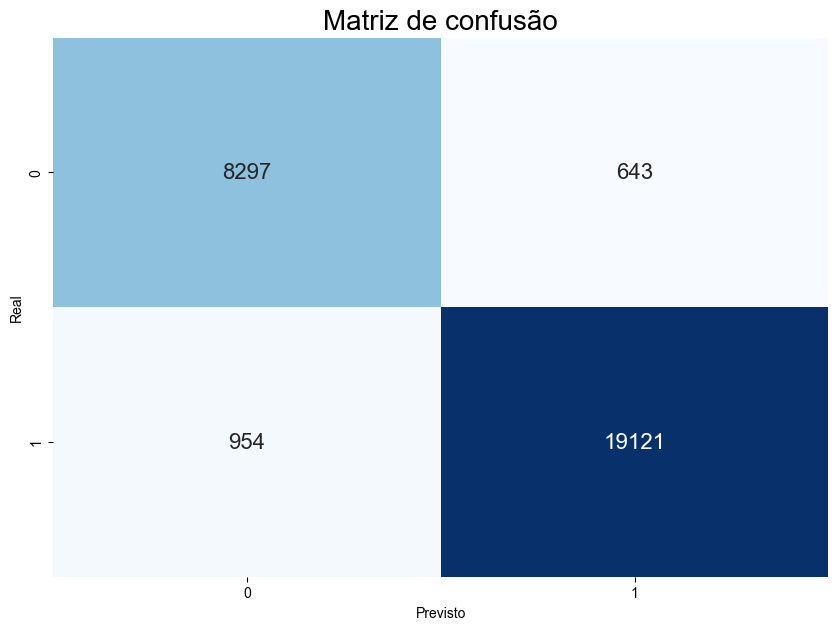

In [20]:
cm_data = confusion_matrix(y_test, y_preds)
cm = pd.DataFrame(cm_data, columns = [0, 1], index = [0, 1])
cm.index.name = 'Real'
cm.columns.name = 'Previsto'
plt.figure(figsize = (10, 7))
plt.title('Matriz de confusão', fontsize = 20)

sns.set(font_scale = 1.4)
ax = sns.heatmap(cm, cbar = False, cmap = "Blues", annot = True, annot_kws = {'size': 16}, fmt = 'g')

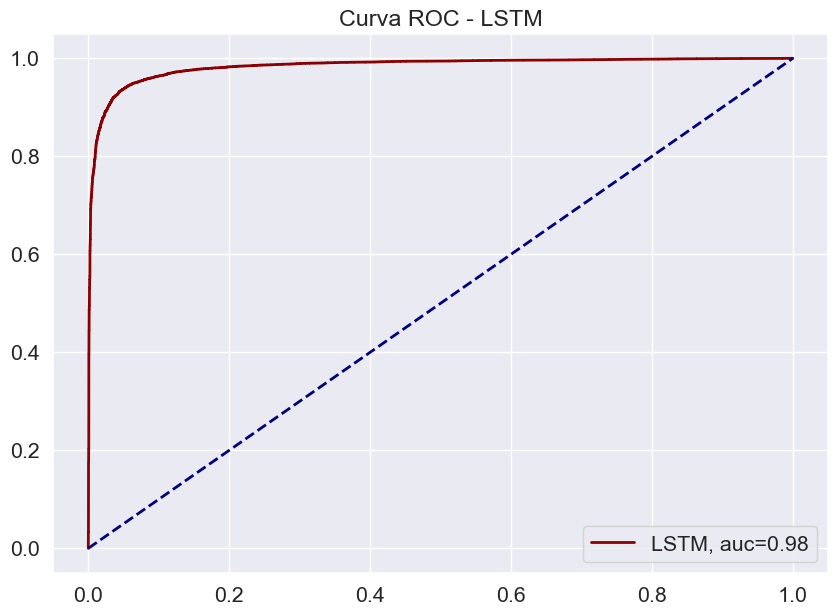

In [21]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_preds_prob)
auc = roc_auc_score(y_test, y_preds_prob)
plt.figure(figsize = (10, 7))
plt.plot(fpr, tpr, color = 'darkred', lw = 2, label = "LSTM, auc=" + str(round(auc, 2)))
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
plt.title('Curva ROC - LSTM')
plt.legend(loc = 4)
plt.show()

# Testando outros modelos de classificação

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

## Regressão logística

In [23]:
lr = LogisticRegression(max_iter = 10000, random_state = 12, n_jobs = 4)
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_test)
print("Acurácia nos dados de treinamento = ", lr.score(X_train, y_train) * 100, "%")
print("Acurácia nos dados de teste = ", lr.score(X_test, y_test) * 100, "%")

Acurácia nos dados de treinamento =  70.75468446629827 %
Acurácia nos dados de teste =  70.80820265379975 %


## Classificador Naive Bayes

In [24]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
nb_preds = nb.predict(X_test)
print("Acurácia nos dados de treinamento = ", nb.score(X_train, y_train) * 100, "%")
print("Acurácia nos dados de teste = ", nb.score(X_test, y_test) * 100, "%")

Acurácia nos dados de treinamento =  72.11378284296266 %
Acurácia nos dados de teste =  72.18679993107014 %


## Classificador SVC

In [25]:
svm = SVC(random_state = 12, verbose = True)
svm.fit(X_train, y_train)
sv_preds = svm.predict(X_test)
print("Acurácia nos dados de treinamento = ", svm.score(X_train, y_train) * 100, "%")
print("Acurácia nos dados de teste = ", svm.score(X_test, y_test) * 100, "%")

[LibSVM]Acurácia nos dados de treinamento =  78.58759463713338 %
Acurácia nos dados de teste =  72.83129415819404 %


## Classificador Random Forest

In [26]:
rfc = RandomForestClassifier(n_estimators = 100, random_state = 12, n_jobs = 4)
rfc.fit(X_train, y_train)
rf_preds = rfc.predict(X_test)
print("Acurácia nos dados de treinamento = ", rfc.score(X_train, y_train) * 100, "%")
print("Acurácia nos dados de teste = ", rfc.score(X_test, y_test) * 100, "%")

Acurácia nos dados de treinamento =  99.97817170823616 %
Acurácia nos dados de teste =  76.08478373255213 %


## Classificador XGBoost

In [27]:
xgb = XGBClassifier(objective = 'binary:logistic',
                    use_label_encoder = False,
                    random_state = 12,
                    eval_metric = 'mlogloss')
xgb.fit(X_train, y_train)
xg_preds = xgb.predict(X_test)
print("Acurácia nos dados de treinamento = ", xgb.score(X_train, y_train) * 100, "%")
print("Acurácia nos dados de teste = ", xgb.score(X_test, y_test) * 100, "%")

Acurácia nos dados de treinamento =  91.20779384901715 %
Acurácia nos dados de teste =  85.59021195933137 %


# Comparação das performances

## Acurácia no conjunto de teste

In [28]:
results = pd.DataFrame(data = [accuracy * 100], columns = ["Rede neural - LSTM"], index = ["Acurácia"])
results['Regressão logística'] = lr.score(X_test, y_test) * 100
results['Classificador Naive Bayes'] = nb.score(X_test, y_test) * 100
results['Classificador SVC'] = svm.score(X_test, y_test) * 100
results['Classificador Random Forest'] = rfc.score(X_test, y_test) * 100
results['Classificador XGBoost'] = xgb.score(X_test, y_test) * 100
results = results.transpose()

In [29]:
x = px.bar(results, y = 'Acurácia', text_auto = True)
x.update_xaxes(title = 'Modelo', categoryorder = 'total descending')
x.update_yaxes(title = 'Acurácia (%)')
x.update_layout(showlegend = True,
  title = {
    'text': 'Acurácia do modelo no conjunto de teste',
    'y': 0.94,
    'x': 0.5,
    'xanchor': 'center',
    'yanchor': 'top'
  })        

x.show()

## Comparação das matrizes de confusão

<AxesSubplot: title={'center': 'Classificador XGBoost'}>

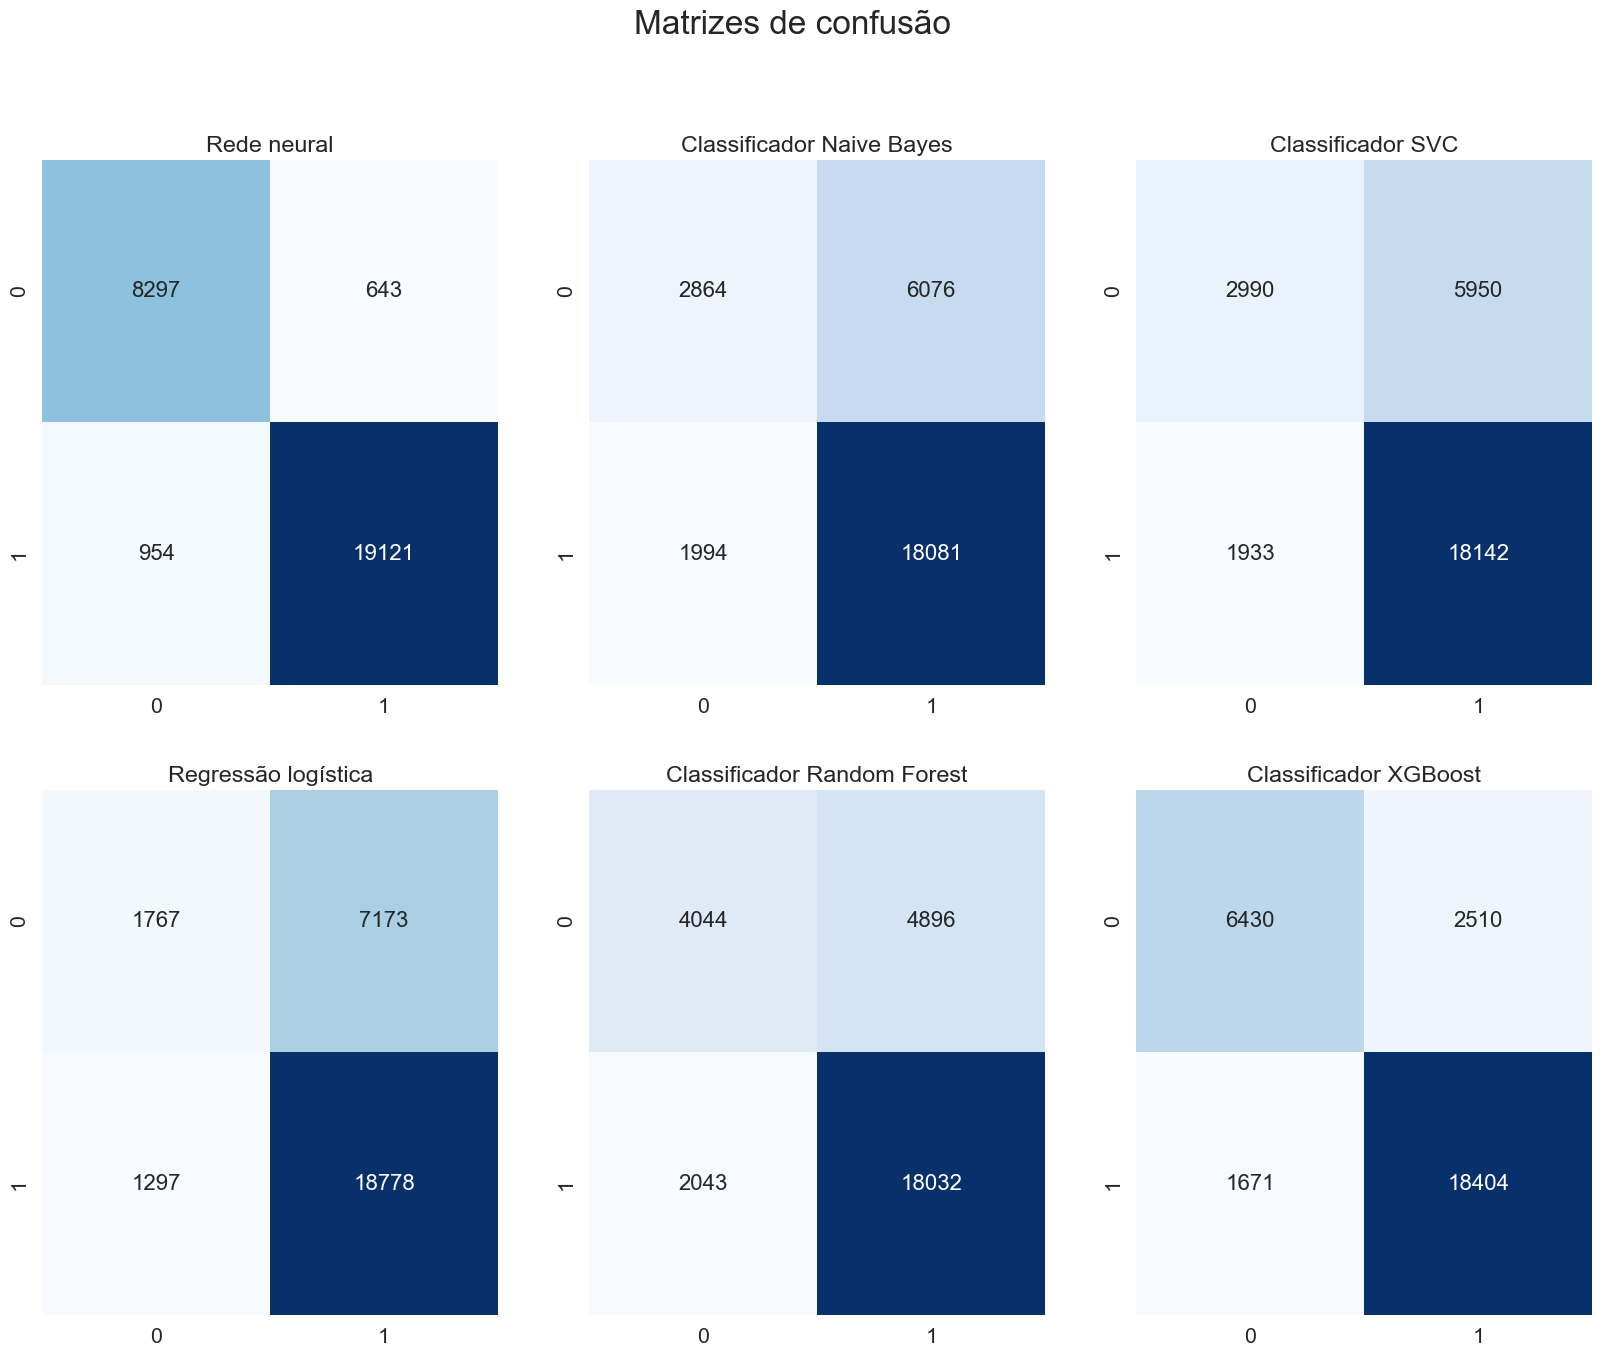

In [30]:
lr_cm = confusion_matrix(y_test, lr_preds)
nb_cm = confusion_matrix(y_test, nb_preds)
svm_cm = confusion_matrix(y_test, sv_preds)
nn_cm = confusion_matrix(y_test, y_preds)
rf_cm = confusion_matrix(y_test, rf_preds)
xg_cm = confusion_matrix(y_test, xg_preds)

plt.figure(figsize = (20, 15))
plt.suptitle('Matrizes de confusão', fontsize = 24)

plt.subplot(2, 3, 1)
plt.title('Rede neural')
sns.heatmap(nn_cm, cbar = False, cmap = 'Blues', annot = True, annot_kws = {'size': 16}, fmt = 'g')

plt.subplot(2, 3, 2)
plt.title('Classificador Naive Bayes')
sns.heatmap(nb_cm, cbar = False, cmap = 'Blues', annot = True, annot_kws = {'size': 16}, fmt = 'g')

plt.subplot(2, 3, 3)
plt.title('Classificador SVC')
sns.heatmap(svm_cm, cbar = False, cmap = 'Blues', annot = True, annot_kws = {'size': 16}, fmt = 'g')

plt.subplot(2, 3, 4)
plt.title('Regressão logística')
sns.heatmap(lr_cm, cbar = False, cmap = 'Blues', annot = True, annot_kws = {'size': 16}, fmt = 'g')

plt.subplot(2, 3, 5)
plt.title('Classificador Random Forest')
sns.heatmap(rf_cm, cbar = False, cmap = 'Blues', annot = True, annot_kws = {'size': 16}, fmt = 'g')

plt.subplot(2, 3, 6)
plt.title('Classificador XGBoost')
sns.heatmap(xg_cm, cbar = False, cmap = 'Blues', annot = True, annot_kws = {'size': 16}, fmt = 'g')

## Comparação das curvas ROC

In [31]:
from sklearn.metrics import auc

pred_lr = lr.predict_proba(X_test)[:,1]
fpr_lr,tpr_lr,_ = roc_curve(y_test,pred_lr)
roc_auc_lr = auc(fpr_lr,tpr_lr)

pred_nb = nb.predict_proba(X_test)[:,1]
fpr_nb,tpr_nb,_ = roc_curve(y_test,pred_nb)
roc_auc_nb = auc(fpr_nb,tpr_nb)

pred_svm = svm.decision_function(X_test)
fpr_svm,tpr_svm,_ = roc_curve(y_test,pred_svm)
roc_auc_svm = auc(fpr_svm,tpr_svm)

fpr_nn, tpr_nn, _  = roc_curve(y_test, y_preds_prob)
roc_auc_nn = auc(fpr_nn,tpr_nn)

pred_rf = rfc.predict_proba(X_test)[:,1]
fpr_rf,tpr_rf,_ = roc_curve(y_test,pred_rf)
roc_auc_rf = auc(fpr_rf,tpr_rf)

pred_xg = xgb.predict_proba(X_test)[:,1]
fpr_xg,tpr_xg,_ = roc_curve(y_test,pred_xg)
roc_auc_xg = auc(fpr_xg,tpr_xg)

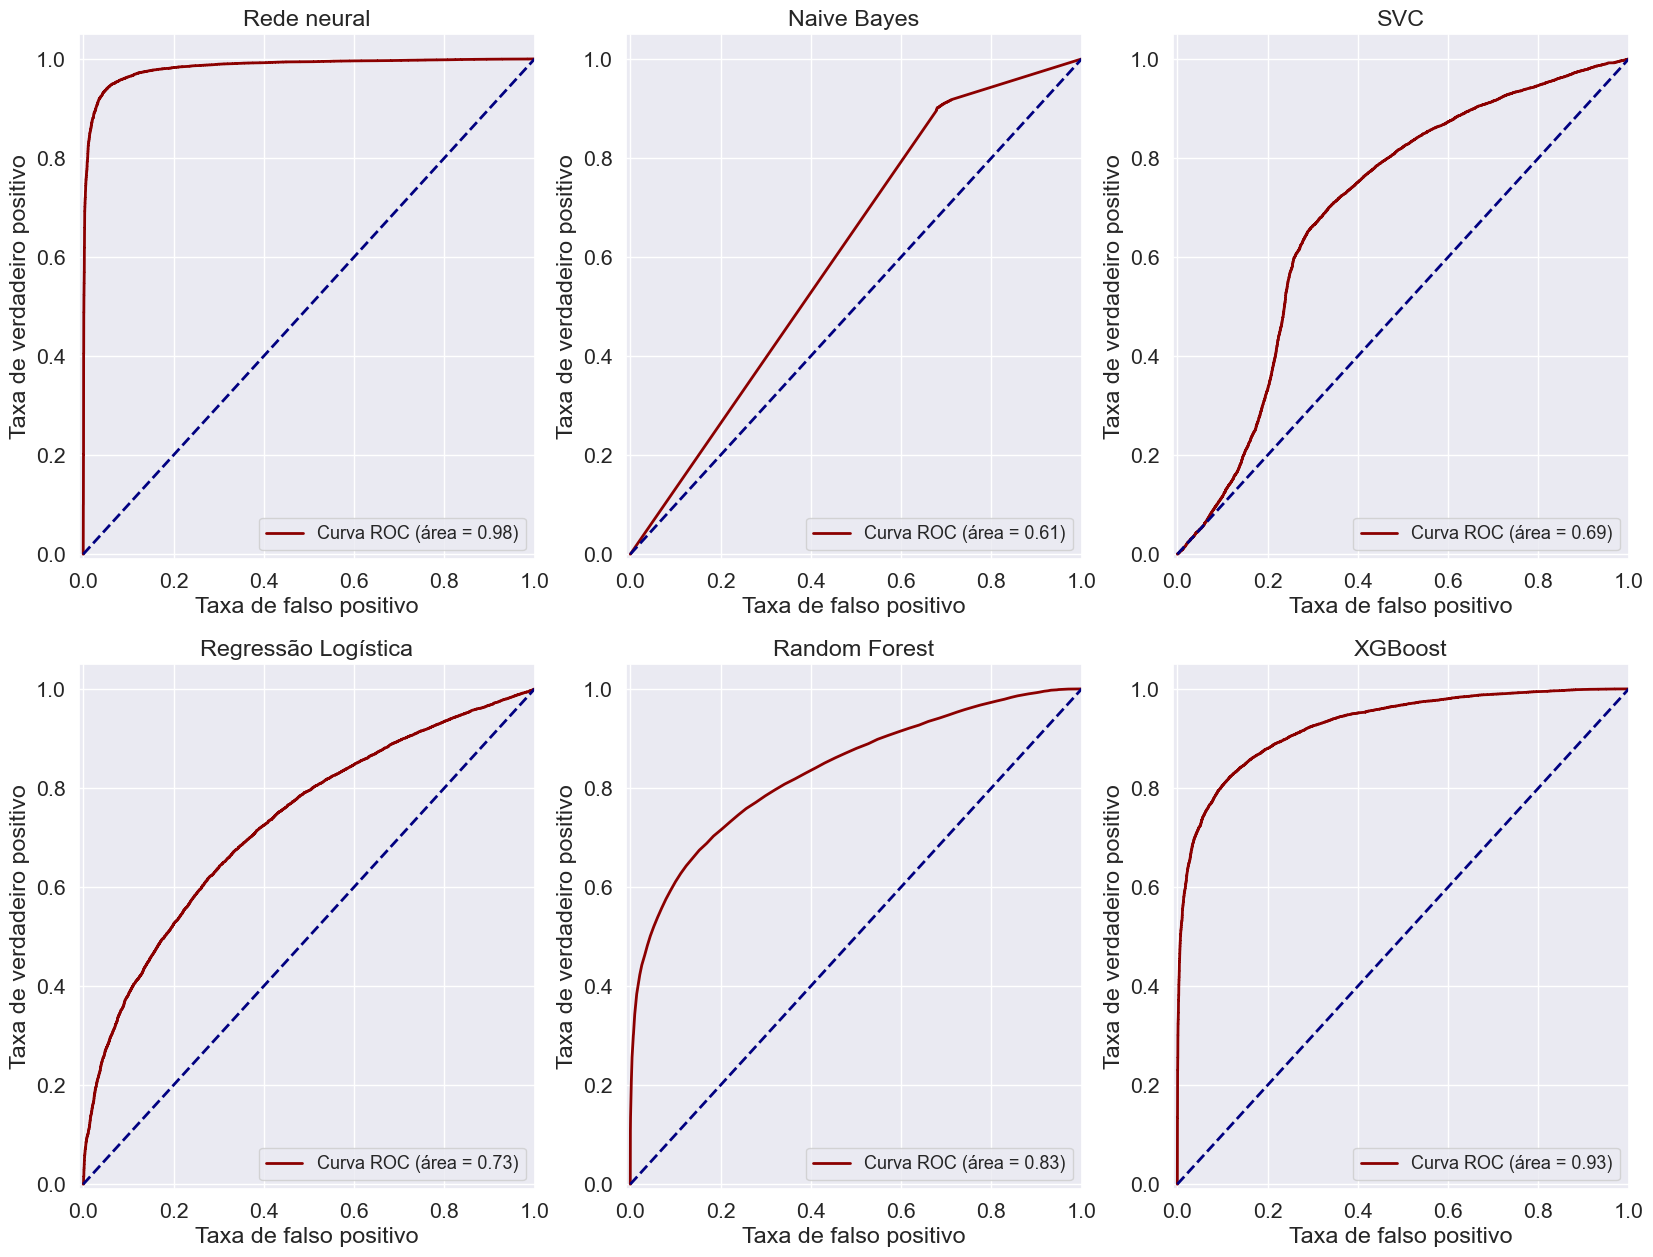

In [32]:
f, axes = plt.subplots(2,3,figsize=(20,15))
axes[0,0].plot(fpr_nn, tpr_nn, color='darkred', lw=2, label='Curva ROC (área = {:0.2f})'.format(roc_auc_nn))
axes[0,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,0].set(xlabel ='Taxa de falso positivo', ylabel = 'Taxa de verdadeiro positivo', title = 'Rede neural')
axes[0,0].legend(loc='lower right', fontsize=13)

axes[0,1].plot(fpr_nb, tpr_nb, color='darkred', lw=2, label='Curva ROC (área = {:0.2f})'.format(roc_auc_nb))
axes[0,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,1].set(xlabel ='Taxa de falso positivo', ylabel = 'Taxa de verdadeiro positivo', title = 'Naive Bayes')
axes[0,1].legend(loc='lower right', fontsize=13)

axes[0,2].plot(fpr_svm, tpr_svm, color='darkred', lw=2, label='Curva ROC (área = {:0.2f})'.format(roc_auc_svm))
axes[0,2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0,2].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[0,2].set(xlabel ='Taxa de falso positivo', ylabel = 'Taxa de verdadeiro positivo', title = 'SVC')
axes[0,2].legend(loc='lower right', fontsize=13)

axes[1,0].plot(fpr_lr, tpr_lr, color='darkred', lw=2, label='Curva ROC (área = {:0.2f})'.format(roc_auc_lr))
axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,0].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,0].set(xlabel ='Taxa de falso positivo', ylabel = 'Taxa de verdadeiro positivo', title = 'Regressão Logística')
axes[1,0].legend(loc='lower right', fontsize=13)

axes[1,1].plot(fpr_rf, tpr_rf, color='darkred', lw=2, label='Curva ROC (área = {:0.2f})'.format(roc_auc_rf))
axes[1,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,1].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,1].set(xlabel ='Taxa de falso positivo', ylabel = 'Taxa de verdadeiro positivo', title = 'Random Forest')
axes[1,1].legend(loc='lower right', fontsize=13)

axes[1,2].plot(fpr_xg, tpr_xg, color='darkred', lw=2, label='Curva ROC (área = {:0.2f})'.format(roc_auc_xg))
axes[1,2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1,2].set(xlim=[-0.01, 1.0], ylim=[-0.01, 1.05])
axes[1,2].set(xlabel ='Taxa de falso positivo', ylabel = 'Taxa de verdadeiro positivo', title = 'XGBoost')
axes[1,2].legend(loc='lower right', fontsize=13)
